In [2]:
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.qubits import e_charge, planck_h, phi0, get_Ic_from_Lj
from qucat import Network,L,J,C
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_ck_to_ground, get_ck
from scipy.optimize import fsolve
from modeling.qubits.clockmon.libraries.clockmon_library_3ports import clockmon_coupling_libraries as clockmon_coupling_libraries_3ports
from modeling.qubits.clockmon.libraries.clockmon_library_3ports import clockmon_cqr_to_ground as clockmon_cqr_to_ground_3ports

from modeling.qubits.clockmon.libraries.clockmon_library_2ports import clockmon_coupling_libraries as clockmon_coupling_libraries_2ports
from modeling.qubits.clockmon.libraries.clockmon_library_2ports import clockmon_cqr_to_ground as clockmon_cqr_to_ground_2ports

from scipy.optimize import minimize


### Direct coupling between qubits
We create a network consisting of the two qubits without coupler, capacitively coupled only through the spurious crosstalk component. We retrieve the coupling strength by inspecting the avoided crossing.

Crosstalk coupling strength: 1.31 kHz


 c:\Users\pc\Desktop\work\.venv\Lib\site-packages\matplotlib\cbook.py: 1699ComplexWarning: Casting complex values to real discards the imaginary part
 c:\Users\pc\Desktop\work\.venv\Lib\site-packages\matplotlib\cbook.py: 1345

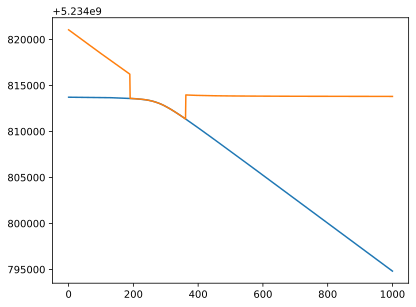

In [3]:
# Crosstalk matrix between S1 and S2
# 1 - Upper pad of qb1
# 2 - Lower pad of qb1
# 3 - Upper pad of qb2
# 4 - Lower pad of qb2
C11 = (147.026 - 37.72 - 0.00659 - 0.006)*1e-15
C12 = 37.72464*1e-15
C13 = 0.00659*1e-15
C14 = 0.00603*1e-15
C22 = (146.96 - 37.72 - 0.00712 - 0.00646)*1e-15
C23 = 0.00712*1e-15
C24 = 0.00646*1e-15
C33 = (147.906 - 37.685 - 0.00659 - 0.00712)*1e-15
C34 = 37.685*1e-15
C44 = (146.4745 - 0.00603 - 0.00646 - 37.685)*1e-15

cir = Network([
    C(0, 1, C11),
    C(1, 2, C12),
    C(1, 3, C13),
    C(1, 4, C14),
    C(2, 3, C23),
    C(2, 0, C22),
    C(2, 4, C24),
    C(0, 3, C33),
    C(3, 4, C34),
    C(0, 4, C44),
    J(2, 1, 'Lj1'),
    J(4, 3, 'Lj2'),
    ])
Lj1_list = np.linspace(10.008e-9,10.0081e-9,1001)
freqs = cir.eigenfrequencies(Lj1=Lj1_list, Lj2 = 10e-9)
energy_diff_mask = abs(freqs[0] - freqs[1]) > 0

g_12 = abs(freqs[0][energy_diff_mask] - freqs[1][energy_diff_mask]).min()/2
# df.loc['spurious crosstalk (shared) [kHz]/2pi'] = [g_12/1e3, g_12/1e3]
print(f"Crosstalk coupling strength: {g_12/1e3 :.2f} kHz")
plt.plot(freqs[0])
plt.plot(freqs[1])

# Note: the crosstalk seems too small to be diagonalised correctly with qucat. We can extract an upper limit by checking the smallest nonzero distance between modes.

### Target parameters 
We set design parameters (CPW traces, permittivity...) and target parameters (frequencies, coupling) 

In [4]:
a = 10e-6
b = 6e-6
ep_r = 11.45
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real

rr_freq_target = np.array([7.4e9, 7.2e9, 7.6e9])
l_rr = Z0*pi/(4*pi*rr_freq_target)
c_rr = 1/((2*pi*rr_freq_target)**2*l_rr)

cplr_freq_target = np.array([7.0e9, 6.8e9])
l_cr = Z0*pi/(4*pi*cplr_freq_target)
c_cr = 1/((2*pi*cplr_freq_target)**2*l_cr)

c_sigma_a = 91e-15
c_sigma_s = 100e-15

chi = 1e6
kappa_target = 2e6
qubit_freq_target = [5e9, 4.5e9, 5.1e9]

g_coupling_target = 90e6
Js1a = g_coupling_target**2*(qubit_freq_target[0] + qubit_freq_target[2] - 2*cplr_freq_target[0]) / (2*(qubit_freq_target[0] - cplr_freq_target[0]) * (qubit_freq_target[2] - cplr_freq_target[0]))
Js2a = g_coupling_target**2*(qubit_freq_target[1] + qubit_freq_target[2] - 2*cplr_freq_target[1]) / (2*(qubit_freq_target[1] - cplr_freq_target[1]) * (qubit_freq_target[2] - cplr_freq_target[1]))


def get_g(EC, Ej, c_coupling, c_r, wr):
    # From Manenti and Motta book
    g = EC/ (e_charge) * (Ej/EC/2)**(1/4) * c_coupling / (c_r) * np.sqrt(2*planck_h * wr * (c_r))
    return g

### Full system network
This 'full system' comprehends the three qubits, ancilla coupling bus, and three readout resonators for a total of 8 coupled oscillators. The coupling/Lj optimization is challenging to carry out, so we reduce the excitation number as much as possible, and use the COBYLA optimizer on the square sum of residuals instead of using fsolve as in simpler chips.

In [5]:
def minimize_function(x, taylor = 5, excitations = [4, 4, 4, 2, 2, 2, 2, 2]):
    c_r_s1 = abs(x[7])*1e-15
    c_r_s2 = abs(x[8])*1e-15
    c_r_a = abs(x[9])*1e-15
    c_c_s1_a_sensing_side =  abs(x[3])*1e-15
    c_c_s1_a_ancilla_side = abs(x[4])*1e-15

    c_c_s2_a_sensing_side = abs(x[5])*1e-15
    c_c_s2_a_ancilla_side = abs(x[6])*1e-15

    Lj_s1 = abs(x[0])*1e-9
    Lj_s2 = abs(x[1])*1e-9
    Lj_a = abs(x[2])*1e-9

    EC_s = e_charge**2/(c_sigma_s)/2/planck_h
    EC_a = e_charge**2/(c_sigma_a)/2/planck_h
    Ic_s1 = get_Ic_from_Lj(Lj_s1)
    Ej_s1 = Ic_s1*phi0/2/pi/planck_h
    Ic_s2 = get_Ic_from_Lj(Lj_s2)
    Ej_s2 = Ic_s2*phi0/2/pi/planck_h
    Ic_a = get_Ic_from_Lj(Lj_a)
    Ej_a = Ic_a*phi0/2/pi/planck_h

    cir = Network([
        C(0,1, c_sigma_s - c_r_s1 - c_c_s1_a_sensing_side), # sensing 1
        J(0,1, Lj_s1),
        C(0,2, c_sigma_s - c_r_s2 - c_c_s2_a_sensing_side), # sensing 2
        J(0,2, Lj_s2),
        C(0,3, c_sigma_a - c_r_a - c_c_s1_a_ancilla_side - c_c_s2_a_ancilla_side), # ancilla
        J(0,3, Lj_a),

        C(0,4, c_rr[0] - c_r_s1), # readout resonator sensing 1
        L(0,4, l_rr[0]),
        C(0,5, c_rr[1] - c_r_s2), # readout resonator sensing 2
        L(0,5, l_rr[1]),
        C(0,6, c_rr[2]- c_r_a), # readout resonator ancilla
        L(0,6, l_rr[2]),


        C(0, 7, c_cr[0] - c_c_s1_a_ancilla_side - c_c_s1_a_sensing_side), # coupling resonator between sensing 1 to ancilla
        L(0, 7, l_cr[0]),
        C(0, 8, c_cr[1]- c_c_s2_a_ancilla_side - c_c_s2_a_sensing_side), # coupling resonator between sensing 2 to ancilla
        L(0, 8, l_cr[1]),

        C(1, 4, c_r_s1), # sensing 1 - readout resonator 1
        C(2, 5, c_r_s2), # sensing 2 - readout resonator 2
        C(3, 6, c_r_a), # ancilla - readout resonator 2


        C(1, 7, c_c_s1_a_sensing_side), # sensing 1 - coupling resonator
        C(3, 7, c_c_s1_a_ancilla_side), # ancilla - coupling resonator

        C(2, 8, c_c_s2_a_sensing_side), # sensing 2 - coupling resonator
        C(3, 8, c_c_s2_a_ancilla_side), # ancilla - coupling resonator

    ])

    g_s1_a_sensing_side = get_g(EC_s, Ej_s1, c_c_s1_a_sensing_side, c_cr[0], cplr_freq_target[0])
    g_s1_a_ancilla_side = get_g(EC_a, Ej_a, c_c_s1_a_ancilla_side, c_cr[0], cplr_freq_target[0])

    g_s2_a_sensing_side = get_g(EC_s, Ej_s2, c_c_s2_a_sensing_side, c_cr[1], cplr_freq_target[1])
    g_s2_a_ancilla_side = get_g(EC_a, Ej_a, c_c_s2_a_ancilla_side, c_cr[1], cplr_freq_target[1])

    gs = [g_s1_a_sensing_side, g_s1_a_ancilla_side, g_s2_a_sensing_side, g_s2_a_ancilla_side]
    H = cir.hamiltonian(modes = [0, 1, 2, 3, 4, 5, 6, 7],
                    taylor = taylor,
                    excitations = excitations)
    eigs = H.eigenenergies().real
    eigs -= eigs[0]

    freq_qb_2 = eigs[1]
    freq_qb_1 = eigs[2]
    freq_qb_a = eigs[3]

    err_g_s1_a_sensing_side = abs((g_s1_a_sensing_side - g_coupling_target) / 1e8)**2
    err_g_s1_a_ancilla_side = abs((g_s1_a_ancilla_side - g_coupling_target) / 1e8)**2
    err_g_s2_a_sensing_side = abs((g_s2_a_sensing_side - g_coupling_target) / 1e8)**2
    err_g_s2_a_ancilla_side = abs((g_s2_a_ancilla_side - g_coupling_target) / 1e8)**2
    err_freq_s1 = abs((freq_qb_1 - qubit_freq_target[0]) / 1e9)**2
    err_freq_s2 = abs((freq_qb_2 - qubit_freq_target[1]) / 1e9)**2
    err_freq_a = abs((freq_qb_a - qubit_freq_target[2]) / 1e9)**2

    chi_s1 = cir.kerr()[1, 6]
    chi_s2 = cir.kerr()[0, 5]
    chi_a = cir.kerr()[2, 7]
    err_chi_s1 = abs((chi_s1 - chi) / 1e6)**2
    err_chi_s2 = abs((chi_s2 - chi) / 1e6)**2
    err_chi_a = abs((chi_a - chi) / 1e6)**2

    cost = np.sum([err_freq_s1, err_freq_s2, err_freq_a, err_g_s1_a_sensing_side, err_g_s1_a_ancilla_side, err_g_s2_a_sensing_side, err_g_s2_a_ancilla_side, err_chi_s1, err_chi_s2, err_chi_a])
    print(err_freq_s1, err_freq_s2, err_freq_a, err_g_s1_a_sensing_side, err_g_s1_a_ancilla_side, err_g_s2_a_sensing_side, err_g_s2_a_ancilla_side, err_chi_s1, err_chi_s2, err_chi_a)
    print(cost)
    return cost

In [6]:
bounds = [(9, 12),
          (10, 13.5),
          (8, 11),
          (2, 7),
          (2, 7),
          (2, 7),
          (2, 7),
          (2, 7),
          (2, 7),
          (2, 7),]
# solution = minimize(minimize_function, [10.7, 12.7,  9.3,  5,5,5,5, 4, 4, 4], method='COBYLA', bounds=bounds, options = {"maxiter": 1000})

In [ ]:
def complete_system(x, taylor = 5, excitations = [4, 4, 4, 2, 2, 2, 2, 2]):
    c_r_s1 = abs(x[7])*1e-15
    c_r_s2 = abs(x[8])*1e-15
    c_r_a = abs(x[9])*1e-15
    c_c_s1_a_sensing_side =  abs(x[3])*1e-15
    c_c_s1_a_ancilla_side = abs(x[4])*1e-15

    c_c_s2_a_sensing_side = abs(x[5])*1e-15
    c_c_s2_a_ancilla_side = abs(x[6])*1e-15

    Lj_s1 = abs(x[0])*1e-9
    Lj_s2 = abs(x[1])*1e-9
    Lj_a = abs(x[2])*1e-9

    EC_s = e_charge**2/(c_sigma_s)/2/planck_h
    EC_a = e_charge**2/(c_sigma_a)/2/planck_h
    Ic_s1 = get_Ic_from_Lj(Lj_s1)
    Ej_s1 = Ic_s1*phi0/2/pi/planck_h
    Ic_s2 = get_Ic_from_Lj(Lj_s2)
    Ej_s2 = Ic_s2*phi0/2/pi/planck_h
    Ic_a = get_Ic_from_Lj(Lj_a)
    Ej_a = Ic_a*phi0/2/pi/planck_h

    cir = Network([
        C(0,1, c_sigma_s - c_r_s1 - c_c_s1_a_sensing_side), # sensing 1
        J(0,1, Lj_s1),
        C(0,2, c_sigma_s - c_r_s2 - c_c_s2_a_sensing_side), # sensing 2
        J(0,2, Lj_s2),
        C(0,3, c_sigma_a - c_r_a - c_c_s1_a_ancilla_side - c_c_s2_a_ancilla_side), # ancilla
        J(0,3, Lj_a),

        C(0,4, c_rr[0] - c_r_s1), # readout resonator sensing 1
        L(0,4, l_rr[0]),
        C(0,5, c_rr[1] - c_r_s2), # readout resonator sensing 2
        L(0,5, l_rr[1]),
        C(0,6, c_rr[2]- c_r_a), # readout resonator ancilla
        L(0,6, l_rr[2]),


        C(0, 7, c_cr[0] - c_c_s1_a_ancilla_side - c_c_s1_a_sensing_side), # coupling resonator between sensing 1 to ancilla
        L(0, 7, l_cr[0]),
        C(0, 8, c_cr[1]- c_c_s2_a_ancilla_side - c_c_s2_a_sensing_side), # coupling resonator between sensing 2 to ancilla
        L(0, 8, l_cr[1]),

        C(1, 4, c_r_s1), # sensing 1 - readout resonator 1
        C(2, 5, c_r_s2), # sensing 2 - readout resonator 2
        C(3, 6, c_r_a), # ancilla - readout resonator 2


        C(1, 7, c_c_s1_a_sensing_side), # sensing 1 - coupling resonator
        C(3, 7, c_c_s1_a_ancilla_side), # ancilla - coupling resonator

        C(2, 8, c_c_s2_a_sensing_side), # sensing 2 - coupling resonator
        C(3, 8, c_c_s2_a_ancilla_side), # ancilla - coupling resonator

    ])

    g_s1_a_sensing_side = get_g(EC_s, Ej_s1, c_c_s1_a_sensing_side, c_cr[0], cplr_freq_target[0])
    g_s1_a_ancilla_side = get_g(EC_a, Ej_a, c_c_s1_a_ancilla_side, c_cr[0], cplr_freq_target[0])

    g_s2_a_sensing_side = get_g(EC_s, Ej_s2, c_c_s2_a_sensing_side, c_cr[1], cplr_freq_target[1])
    g_s2_a_ancilla_side = get_g(EC_a, Ej_a, c_c_s2_a_ancilla_side, c_cr[1], cplr_freq_target[1])

    gs = [g_s1_a_sensing_side, g_s1_a_ancilla_side, g_s2_a_sensing_side, g_s2_a_ancilla_side]
    H = cir.hamiltonian(modes = [0, 1, 2, 3, 4, 5, 6, 7],
                    taylor = taylor,
                    excitations = excitations)

    return cir, H, gs

In [27]:
solution_preloaded = np.array([ 9.3612954 , 11.45992734,  9.81798915,  5.03033904,  4.74285582,
        5.4465527 ,  4.8823484 ,  4.96991825,  5.92406338,  4.49224097])

In [28]:
cir, H, gs = complete_system(solution_preloaded, taylor = 5, excitations = [4, 4, 4, 2, 2, 2, 2, 2])
_ = cir.f_k_A_chi(pretty_print=True)

 c:\Users\pc\Desktop\work\.venv\Lib\site-packages\qucat\core.py: 2446

         mode |       freq.  |       diss.  |       anha.  |
            0 |      4.7 GHz |          0Hz |      192 MHz |
            1 |      5.2 GHz |          0Hz |      192 MHz |
            2 |     5.32 GHz |          0Hz |      209 MHz |
            3 |     6.94 GHz |          0Hz |     4.12 kHz |
            4 |     7.14 GHz |          0Hz |     4.32 kHz |
            5 |     7.21 GHz |          0Hz |     1.34 kHz |
            6 |     7.41 GHz |          0Hz |     1.35 kHz |
            7 |     7.61 GHz |          0Hz |     1.22 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |         2    |         3    |         4    |         5    |         6    |         7    |
            0 |      192 MHz |              |              |              |              |              |              |              |
            1 |      10.2 Hz |      192 MHz |              |              |              |              |          

In [10]:
eigs = H.eigenenergies().real
eigs -= eigs[0]
eigs[1:9]

array([4.49995687e+09, 5.00000106e+09, 5.10001104e+09, 6.81411834e+09,
       7.01438349e+09, 7.20814283e+09, 7.40687667e+09, 7.60649924e+09])

In [11]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi #/ np.sqrt(2)
    return abs(k - kappa_target)

cks = np.zeros((3))
for i in range(3):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15

In [12]:
# array([4.50001095e+09, 5.00000489e+09, 5.09998591e+09, 6.81417126e+09,
#        7.01447256e+09, 7.20365948e+09, 7.40309202e+09, 7.60359863e+09])
# Lj_s1, Lj2, Lj_a, c_c_s1_a_sensing_side, c_c_s1_a_ancilla_side, c_c_s2_a_sensing_side, c_c_s2_a_ancilla_side, c_r_s1, c_r_s2, c_r_a = solution.x

In [13]:
solution_preloaded

array([ 9.3612954 , 11.45992734,  9.81798915,  5.03033904,  4.74285582,
        5.4465527 ,  4.8823484 ,  4.96991825,  5.92406338,  4.49224097])

In [14]:
Lj_s1, Lj_s2, Lj_a, c_c_s1_a_sensing_side, c_c_s1_a_ancilla_side, c_c_s2_a_sensing_side, c_c_s2_a_ancilla_side, c_r_s1, c_r_s2, c_r_a = solution_preloaded*np.array([1e-9, 1e-9, 1e-9, 1e-15, 1e-15, 1e-15, 1e-15, 1e-15, 1e-15, 1e-15])

In [15]:
Ic_s1 = get_Ic_from_Lj(Lj_s1)
Ej_s1 = Ic_s1*phi0/2/pi/planck_h
Ic_s2 = get_Ic_from_Lj(Lj_s2)
Ej_s2 = Ic_s2*phi0/2/pi/planck_h
Ic_a = get_Ic_from_Lj(Lj_a)
Ej_a = Ic_a*phi0/2/pi/planck_h

g_s1 = get_g(e_charge**2/(c_sigma_s)/2/planck_h, Ej_s1, c_r_s1, c_rr[0], rr_freq_target[0])
g_s2 = get_g(e_charge**2/(c_sigma_s)/2/planck_h, Ej_s2, c_r_s2, c_rr[1], rr_freq_target[1])
g_a = get_g(e_charge**2/(c_sigma_a)/2/planck_h, Ej_a, c_r_a, c_rr[2], rr_freq_target[2])

In [16]:
np.save("params_", np.array([Lj_s1, Lj_s2, Lj_a, c_c_s1_a_sensing_side, c_c_s1_a_ancilla_side, c_c_s2_a_sensing_side, c_c_s2_a_ancilla_side, c_r_s1, c_r_s2, c_r_a, g_s1, g_s2, g_a, cks[0], cks[1], cks[2]]))

In [17]:
ancilla_lib = clockmon_coupling_libraries_3ports(port_id = "3_4_5")
sensing_lib = clockmon_coupling_libraries_2ports(port_id = "0_3", alternative_geometry=True)

# qb2_lib = clockmon_coupling_libraries(port_id = "0_3")
ck_given_coupling = get_ck()

ancilla_coupler_widths = ancilla_lib(c_c_s2_a_ancilla_side, c_c_s1_a_ancilla_side, c_r_a)
sensing1_coupler_widths = sensing_lib(c_c_s1_a_sensing_side, c_r_s1)
sensing2_coupler_widths = sensing_lib(c_c_s2_a_sensing_side, c_r_s2)

finger_control = ck_given_coupling(cks)

print(f"Coupler 3 width for qubit ancilla: {ancilla_coupler_widths[0]:.5} um")
print(f"Coupler 4 width for qubit ancilla: {ancilla_coupler_widths[1]:.5} um")
print(f"Coupler 5 width for qubit ancilla: {ancilla_coupler_widths[2]:.5} um")

print(f"Coupler 0 width for qubit sensing 1: {sensing1_coupler_widths[0]:.5} um")
print(f"Coupler 3 width for qubit sensing 1: {sensing1_coupler_widths[1]:.5} um")
print(f"Coupler 0 width for qubit sensing 2: {sensing2_coupler_widths[0]:.5} um")
print(f"Coupler 3 width for qubit sensing 2: {sensing2_coupler_widths[1]:.5} um")

print(f"Finger control for sensing 1: {finger_control[0]:.5}")
print(f"Finger control for sensing 2: {finger_control[1]:.5}")
print(f"Finger control for ancilla: {finger_control[2]:.5}")

Coupler 3 width for qubit ancilla: 149.3 um
Coupler 4 width for qubit ancilla: 154.43 um
Coupler 5 width for qubit ancilla: 157.05 um
Coupler 0 width for qubit sensing 1: 155.68 um
Coupler 3 width for qubit sensing 1: 153.38 um
Coupler 0 width for qubit sensing 2: 173.9 um
Coupler 3 width for qubit sensing 2: 193.11 um
Finger control for sensing 1: 2.1464
Finger control for sensing 2: 2.1804
Finger control for ancilla: 2.1132


# Waveguide length estimation
Here we estimate the waveguide length to be set in "dimensioned chip", by taking into account the coupling loads and the added capacitance and inductance to ground given by couplers.

In [18]:
# ancilla couplers to ground
ancilla_3 = clockmon_cqr_to_ground_3ports(port_id = "3_4_5", ground_id = 0)
ancilla_4 = clockmon_cqr_to_ground_3ports(port_id = "3_4_5", ground_id = 1)
ancilla_5 = clockmon_cqr_to_ground_3ports(port_id = "3_4_5", ground_id = 2)

# sensing couplers to ground
sensing_0 = clockmon_cqr_to_ground_2ports(port_id = "0_3", ground_id = 0, alternative_geometry=True)
sensing_3 = clockmon_cqr_to_ground_2ports(port_id = "0_3", ground_id = 1, alternative_geometry=True)

# cks
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])

In [19]:
# Coupler s1-a (lambda/2)
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_length = v_ph / cplr_freq_target[0] / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_length*c_l - ancilla_4((c_c_s2_a_ancilla_side, c_c_s1_a_ancilla_side, c_r_a)) - sensing_0((c_c_s1_a_sensing_side, c_r_s1)))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_length*c_l - ancilla_4((c_c_s2_a_ancilla_side, c_c_s1_a_ancilla_side, c_r_a)) - sensing_0((c_c_s1_a_sensing_side, c_r_s1)))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded -= (c_c_s1_a_sensing_side + c_c_s1_a_ancilla_side)
cplr_waveguide_length = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
print(f"Waveguide length for coupler s1-a: {cplr_waveguide_length*1e6 : 2f} um")


# bare_length = v_ph / (2 * cplr_freq_target[0])
# freq_loaded = 1 / np.sqrt((l_cr[0]) * (c_cr[0] + (c_c_s1_a_sensing_side + c_c_s1_a_ancilla_side))) / 2 / np.pi
# correction_factor = cplr_freq_target[0] / freq_loaded
# corrected_length = bare_length / correction_factor
# corrected_length
# print(f"Waveguide length for coupler s1-a {corrected_length*1e6 : 2f} um")

Waveguide length for coupler s1-a:  8273.203691 um


In [20]:
# Coupler s2-a (lambda/2)
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_length = v_ph / cplr_freq_target[1] / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_length*c_l - ancilla_3((c_c_s2_a_ancilla_side, c_c_s1_a_ancilla_side, c_r_a)) - sensing_0((c_c_s2_a_sensing_side, c_r_s2)))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_length*c_l - ancilla_3((c_c_s2_a_ancilla_side, c_c_s1_a_ancilla_side, c_r_a)) - sensing_0((c_c_s2_a_sensing_side, c_r_s2)))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded -= (c_c_s2_a_sensing_side + c_c_s2_a_ancilla_side)
cplr_waveguide_length = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
print(f"Waveguide length for coupler s2-a: {cplr_waveguide_length*1e6 : 2f} um")


# bare_length = v_ph / (2 * cplr_freq_target[1])
# freq_loaded = 1 / np.sqrt((l_cr[1]) * (c_cr[1] + (c_c_s2_a_sensing_side + c_c_s2_a_ancilla_side))) / 2 / np.pi
# correction_factor = cplr_freq_target[1] / freq_loaded
# corrected_length = bare_length / correction_factor
# corrected_length
# print(f"Waveguide length for coupler s2-a {corrected_length*1e6 : 2f} um")

Waveguide length for coupler s2-a:  8532.261970 um


In [21]:
# Readout s1 (lambda/2)
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_length = v_ph / rr_freq_target[0] / 2
# l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_length*c_l - sensing_3((c_c_s1_a_sensing_side, c_r_s1)) - ck_to_ground(cks[0]))*
#                                 (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
# c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_length*c_l - sensing_3((c_c_s1_a_sensing_side, c_r_s1)) - ck_to_ground(cks[0]))*
#                                 (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))

l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_length*c_l - sensing_3((c_c_s1_a_sensing_side, c_r_s1)) - ck_to_ground(cks[0]))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_length*c_l - sensing_3((c_c_s1_a_sensing_side, c_r_s1)) - ck_to_ground(cks[0]))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))

c_r_loaded -= (c_r_s1 + cks[0])
cplr_waveguide_length = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
print(f"Waveguide length for S1 readout resonator: {cplr_waveguide_length*1e6 : 2f} um")



# Let's use this method instead
# https://qct.ifae.es/files/Alberto_Lajara_Coplanar_Waveguide_Resonators_for_QC_2020.pdf
# https://arxiv.org/pdf/0807.4094 !! this

# bare_length = v_ph / (2 * rr_freq_target[0])
# freq_loaded = 1 / np.sqrt((l_rr[0]) * (c_rr[0] + (c_r_s1 + cks[0]))) / 2 / np.pi
# correction_factor = rr_freq_target[0] / freq_loaded
# corrected_length = bare_length / correction_factor
# corrected_length
# print(f"Waveguide length for S1 readout resonator: {corrected_length*1e6 : 2f} um")


Waveguide length for S1 readout resonator:  7779.673544 um


In [22]:
# Readout s2 (lambda/2)
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_length = v_ph / rr_freq_target[1] / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_length*c_l - sensing_3((c_c_s2_a_sensing_side, c_r_s2)) - ck_to_ground(cks[1]))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_length*c_l - sensing_3((c_c_s2_a_sensing_side, c_r_s2)) - ck_to_ground(cks[1]))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded -= (c_r_s2 + cks[1])
cplr_waveguide_length = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
print(f"Waveguide length for S2 readout resonator: {cplr_waveguide_length*1e6 : 2f} um")

# bare_length = v_ph / (2 * rr_freq_target[1])
# freq_loaded = 1 / np.sqrt(l_rr[1] * (c_rr[1] + (c_r_s2 + cks[1]))) / 2 / np.pi
# correction_factor = rr_freq_target[1] / freq_loaded
# corrected_length = bare_length / correction_factor
# corrected_length
# print(f"Waveguide length for S2 readout resonator: {corrected_length*1e6 : 2f} um")

Waveguide length for S2 readout resonator:  7975.475831 um


In [23]:
# Readout a (lambda/2)
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_length = v_ph / rr_freq_target[2] / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_length*c_l - ancilla_5((c_c_s2_a_ancilla_side, c_c_s1_a_ancilla_side, c_r_a)) - ck_to_ground(cks[2]))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_length*c_l - ancilla_5((c_c_s2_a_ancilla_side, c_c_s1_a_ancilla_side, c_r_a))  - ck_to_ground(cks[2]))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded -= (c_r_s2 + cks[2])
cplr_waveguide_length = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
print(f"Waveguide length for ancilla readout resonator: {cplr_waveguide_length*1e6 : 2f} um")


# bare_length = v_ph / (2 * rr_freq_target[2])
# freq_loaded = 1 / np.sqrt(l_rr[2] * (c_rr[2] + (c_r_a + cks[2]))) / 2 / np.pi
# correction_factor = rr_freq_target[2] / freq_loaded
# corrected_length = bare_length / correction_factor
# corrected_length
# print(f"Waveguide length for ancilla readout resonator: {corrected_length*1e6 : 2f} um")

Waveguide length for ancilla readout resonator:  7537.829159 um
